# Notebook showing a fast and efficient way to load Sentinel-2 L1C data into xarray

In [4]:
import glob
import os
import numpy as np

import pandas as pd
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap
from s2driver import driver_S2_SAFE as S2

import memory_profiler


%load_ext memory_profiler


opj = os.path.join

Set the path of the images you want to load, here is a example for the former (v3) and current (v4) image formatting 

In [5]:
imageSAFE_v3 = '/sat_data/satellite/sentinel2/L1C/31TFJ/S2A_MSIL1C_20201004T104031_N0209_R008_T31TFJ_20201004T125253.SAFE'
imageSAFE_v4 = '/sat_data/satellite/sentinel2/L1C/31TFJ/S2B_MSIL1C_20220731T103629_N0400_R008_T31TFJ_20220731T124834.SAFE'

First, check the availbale bands:

In [7]:
S2.INFO

bandId,0,1,2,3,4,5,6,7,8,9,10,11,12
ESA,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12
EOREADER,CA,BLUE,GREEN,RED,VRE_1,VRE_2,VRE_3,NARROW_NIR,NIR,WV,SWIR_CIRRUS,SWIR_1,SWIR_2
Wavelength (nm),443,490,560,665,705,740,783,842,865,945,1375,1610,2190
Band width (nm),20,65,35,30,15,15,20,115,20,20,30,90,180
Resolution (m),60,10,10,10,20,20,20,10,20,60,60,20,20


Choose the bands to be loaded (fill the bandIds array up) and the resolution between 10, 20 and 60 m:

In [8]:
bandIds = [0,1,2,3,8,12]
resolution=20

Create the s2driver objects for the selected images

In [9]:
image = imageSAFE_v3
l1c = S2.s2image(image,band_idx=bandIds,resolution=resolution)


From that stage you can check some metadata such as the crs and geometry related attributes:

In [13]:
print(l1c.crs)
l1c.metadata

EPSG:32631


{'CLOUD_COVERAGE_ASSESSMENT': '27.9283',
 'DATATAKE_1_DATATAKE_SENSING_START': '2020-10-04T10:40:31.024Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20201004T104031_027604_N02.09',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '8',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0.0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((5.616539589319299 44.223381404731654, 5.571981932015927 44.11139303082744, 5.514169764593674 43.96579155590467, 5.456552687224091 43.8201245960835, 5.400810982659208 43.673932437925735, 5.343737413584174 43.52802806036848, 5.286126192453249 43.382249294409526, 5.231468869395808 43.24147973888405, 4.232032700041831 43.25815531909012, 4.252480872223193 44.24655093494868, 5.616539589319299 44.223381404731654))',
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': '2020-10-04T12:52:53.000000Z',
 'GEOMETRIC_QUALITY': 'PASS

Load angles and get the *geom* xarray

In [15]:
%time %memit l1c.load_geom()

0
1
2
3
8
12
peak memory: 4928.62 MiB, increment: 4590.91 MiB
CPU times: user 9.78 s, sys: 2.53 s, total: 12.3 s
Wall time: 12.4 s


Load band reflectances and get the *bands* xarray 


In [28]:
%time %memit l1c.load_bands()

peak memory: 7930.73 MiB, increment: 2433.36 MiB
CPU times: user 2min 15s, sys: 6.95 s, total: 2min 22s
Wall time: 23.7 s


# Plotting section
The MSI-Sentinel-2 instrument is composed of 12 detectors staggered in two different rows making a "switch" in viewng geometries along the image especially for the azimuth values. Here, we plot the solar and viewing zenith angles as well as the relative azimuth between Sun and sensor directions.
The sun viewing angle (SZA) is common to all the spectral bands.

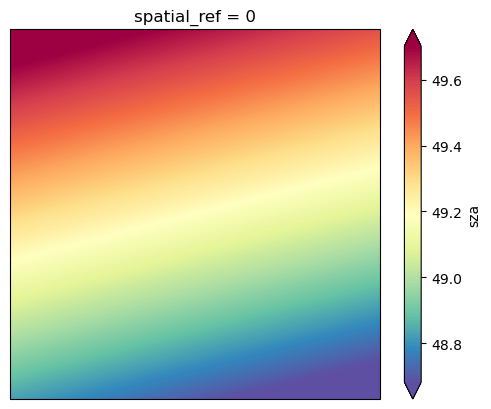

In [18]:
coarsening = 10
p = l1c.geom.sza[::coarsening, ::coarsening].plot.imshow(subplot_kws=dict(projection= l1c.proj), robust=True, cmap=plt.cm.Spectral_r)

The sensor angles are dependent on the spectral band considered, here are the viewing zenith angle (VZA) and the relative azimuth (RAZI) for the bands loaded in the S2 object.
## VZA

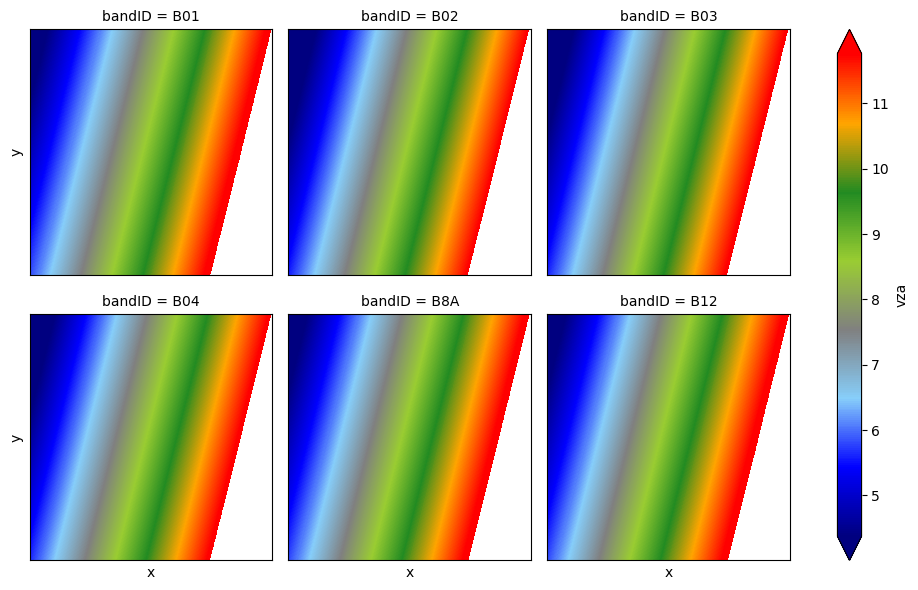

In [49]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("",['navy', "blue", 'lightskyblue', 'gray', 'yellowgreen', 'forestgreen', 'orange', 'red'])
fig = l1c.geom.vza.plot.imshow(col='bandID', cmap=cmap, col_wrap=3,  robust=True,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

## RAZI

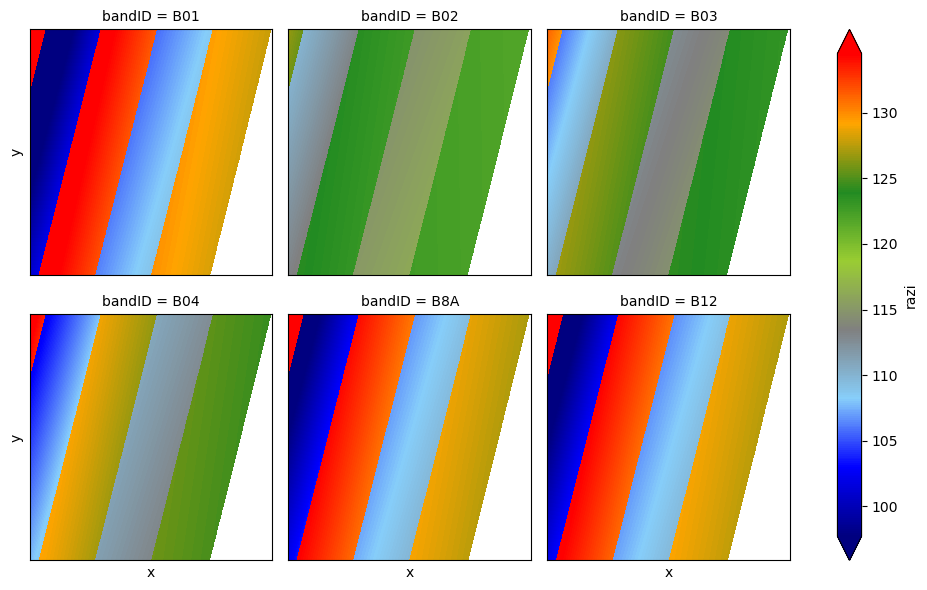

In [33]:
fig = l1c.geom.razi.plot.imshow(col='bandID', cmap=cmap, col_wrap=3, aspect=1, robust=True,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

Check the difference between two bands (e.g., B02-B8A)

In [42]:
diff = l1c.geom.sel(bandID='B02')-l1c.geom.sel(bandID='B8A')


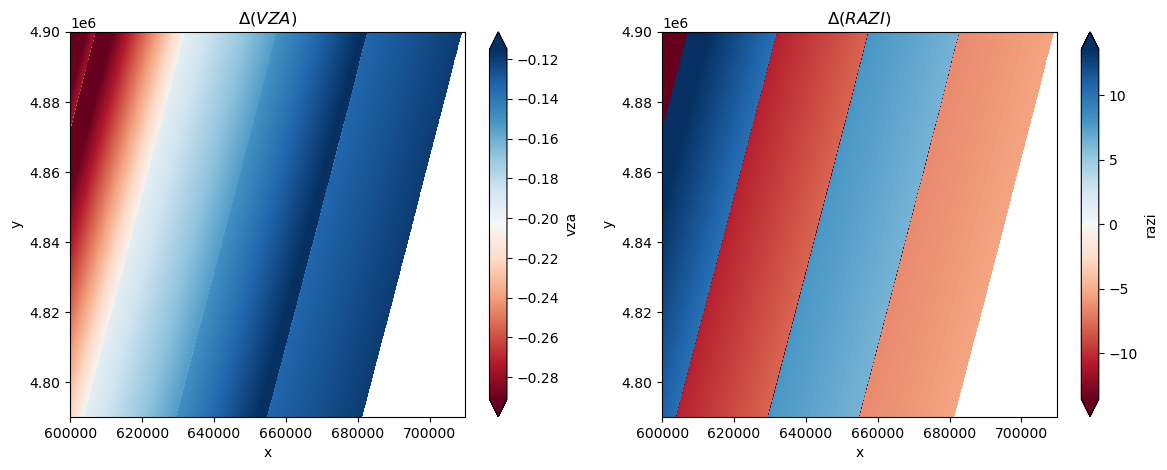

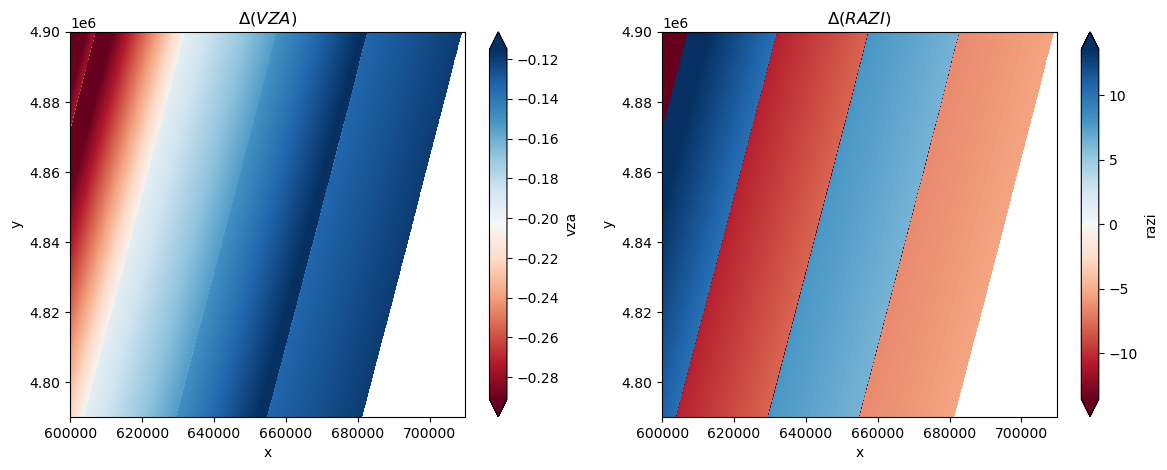

In [50]:
fig, axs = plt.subplots(ncols=2,figsize=(14,5))
diff.vza.plot.imshow(ax=axs[0],cmap=plt.cm.RdBu, robust=True)
axs[0].set_title('$\Delta (VZA)$')
diff.razi.plot.imshow(ax=axs[1],cmap=plt.cm.RdBu, robust=True)
axs[1].set_title('$\Delta (RAZI)$')
fig

The reflectance data can also be easily plotted:

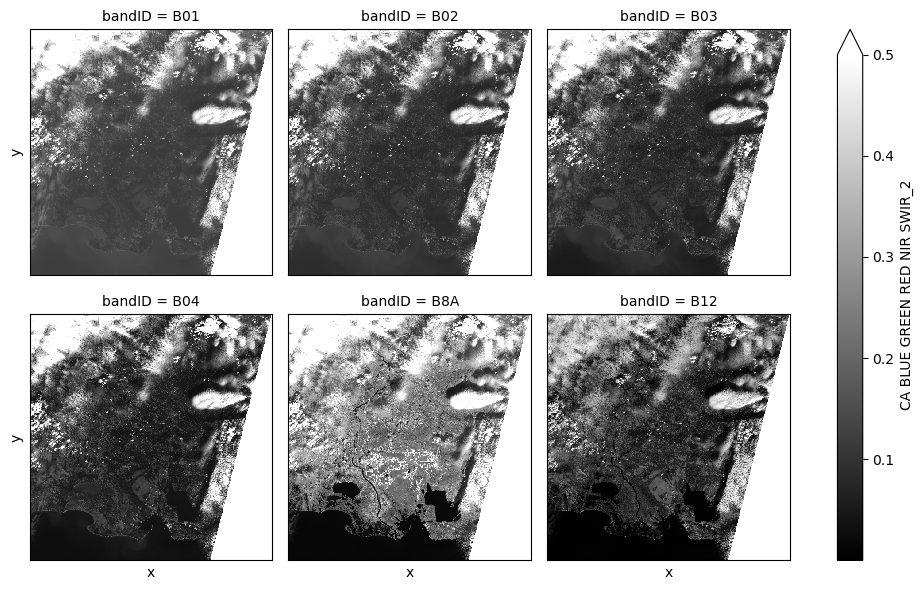

In [48]:

p = l1c.bands[:, ::coarsening, ::coarsening].plot.imshow(col='bandID', col_wrap=3,  vmax=0.5, cmap=plt.cm.binary_r,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

And the RGB image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


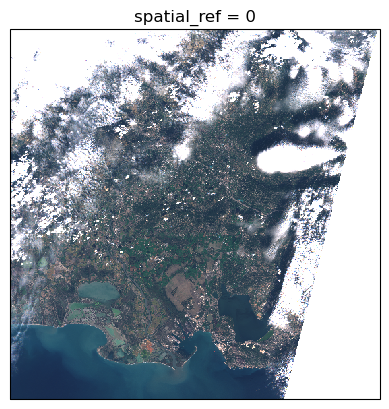

In [58]:
brightness_factor = 3.5
(l1c.bands[:, ::coarsening, ::coarsening].sel(bandID=['B04','B03','B02'])*brightness_factor).plot.imshow(rgb='bandID', subplot_kws=dict(projection= l1c.proj))

In [59]:
import os
print(os.environ['PATH'])

/home/harmel/anaconda3/envs/s2driver/bin:/home/harmel/anaconda3/condabin:/home/harmel/.local/bin:/home/harmel/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/lib/jvm/java-17-oracle/bin:/usr/lib/jvm/java-17-oracle/db/bin
